In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load the data directly from the CSV file
data = pd.read_csv('../data/1/heart_failure_clinical_records_dataset.csv')

# Separate features and target
X = data.drop('DEATH_EVENT', axis=1)
y = data['DEATH_EVENT']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale features for better model performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Define classification models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Initialize a DataFrame to store results
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # For ROC AUC, we need probability estimates
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # Some models like SVC with linear kernel don't have predict_proba by default
        y_pred_proba = y_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Add results to DataFrame
    results = pd.concat([results, pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'ROC AUC': [roc_auc]
    })], ignore_index=True)

# Sort results by F1 score (higher is better)
results = results.sort_values('F1 Score', ascending=False)

print("Heart Failure Prediction Model Performance Comparison:")
print(results.round(4))



Heart Failure Prediction Model Performance Comparison:
                 Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
0  Logistic Regression    0.7733     0.8500  0.5484    0.6667   0.8152
2        Random Forest    0.7333     0.7391  0.5484    0.6296   0.8383
3    Gradient Boosting    0.7200     0.7083  0.5484    0.6182   0.8512
4                  SVM    0.7200     0.7778  0.4516    0.5714   0.8079
1        Decision Tree    0.6400     0.5909  0.4194    0.4906   0.6074
5                  KNN    0.6800     0.7692  0.3226    0.4545   0.7302


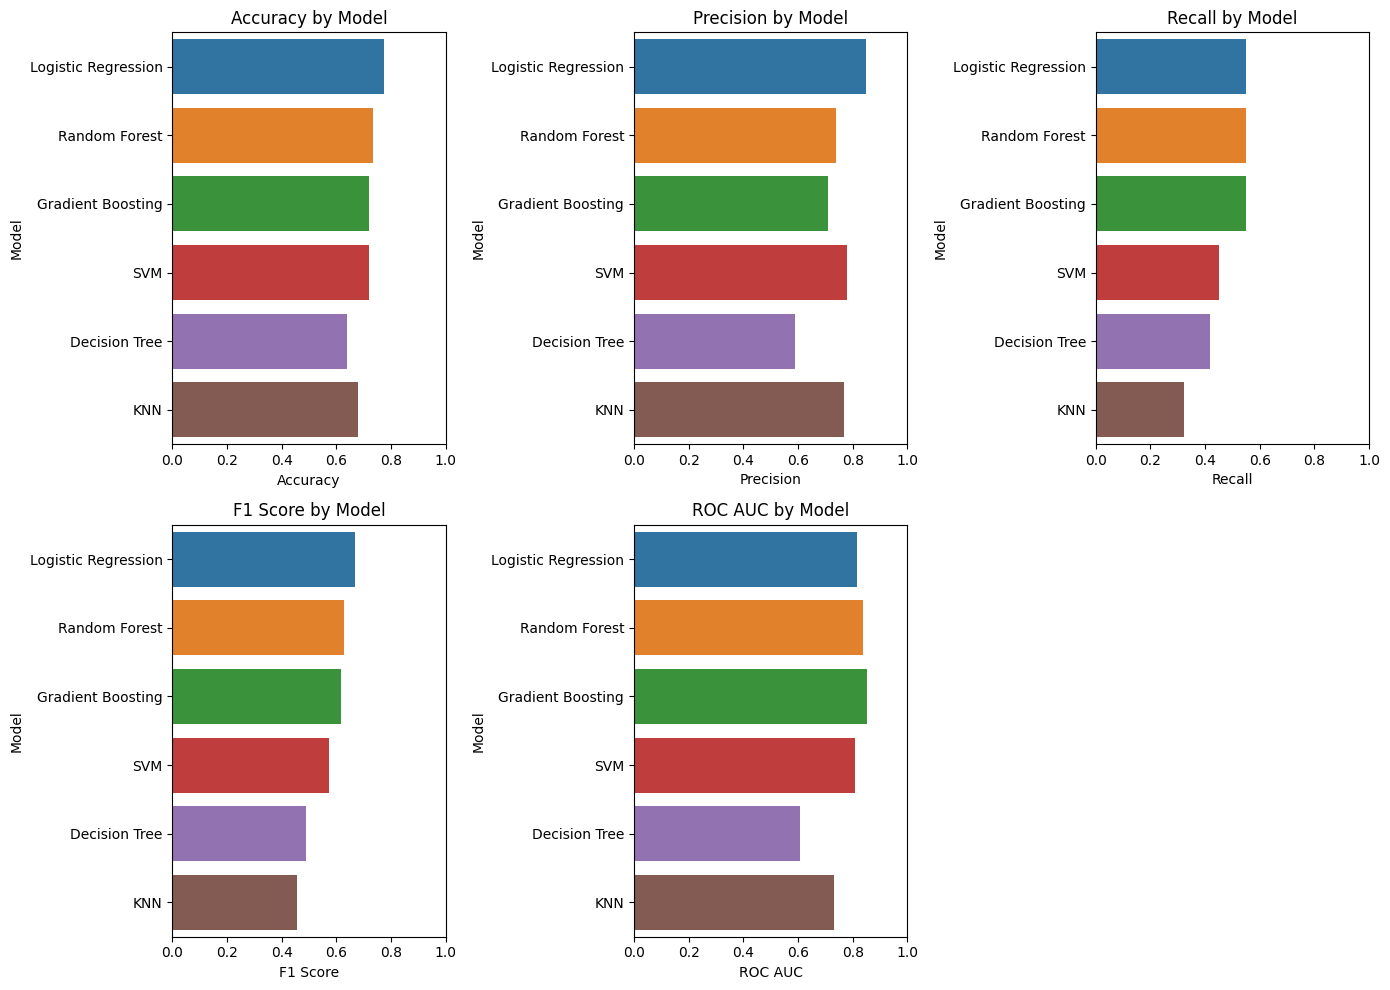

In [13]:
# Visualize the results
plt.figure(figsize=(14, 10))

# Accuracy
plt.subplot(2, 3, 1)
sns.barplot(x='Accuracy', y='Model', data=results)
plt.title('Accuracy by Model')
plt.xlim(0, 1)

# Precision
plt.subplot(2, 3, 2)
sns.barplot(x='Precision', y='Model', data=results)
plt.title('Precision by Model')
plt.xlim(0, 1)

# Recall
plt.subplot(2, 3, 3)
sns.barplot(x='Recall', y='Model', data=results)
plt.title('Recall by Model')
plt.xlim(0, 1)

# F1 Score
plt.subplot(2, 3, 4)
sns.barplot(x='F1 Score', y='Model', data=results)
plt.title('F1 Score by Model')
plt.xlim(0, 1)

# ROC AUC
plt.subplot(2, 3, 5)
sns.barplot(x='ROC AUC', y='Model', data=results)
plt.title('ROC AUC by Model')
plt.xlim(0, 1)

plt.tight_layout()
plt.show()




Top 15 Features Importance (Random Forest):
                     Feature  Importance
11                      time    0.392223
7           serum_creatinine    0.153971
4          ejection_fraction    0.100186
0                        age    0.090532
6                  platelets    0.076847
2   creatinine_phosphokinase    0.069255
8               serum_sodium    0.062506
3                   diabetes    0.011974
9                        sex    0.011386
1                    anaemia    0.011322
10                   smoking    0.010649
5        high_blood_pressure    0.009148


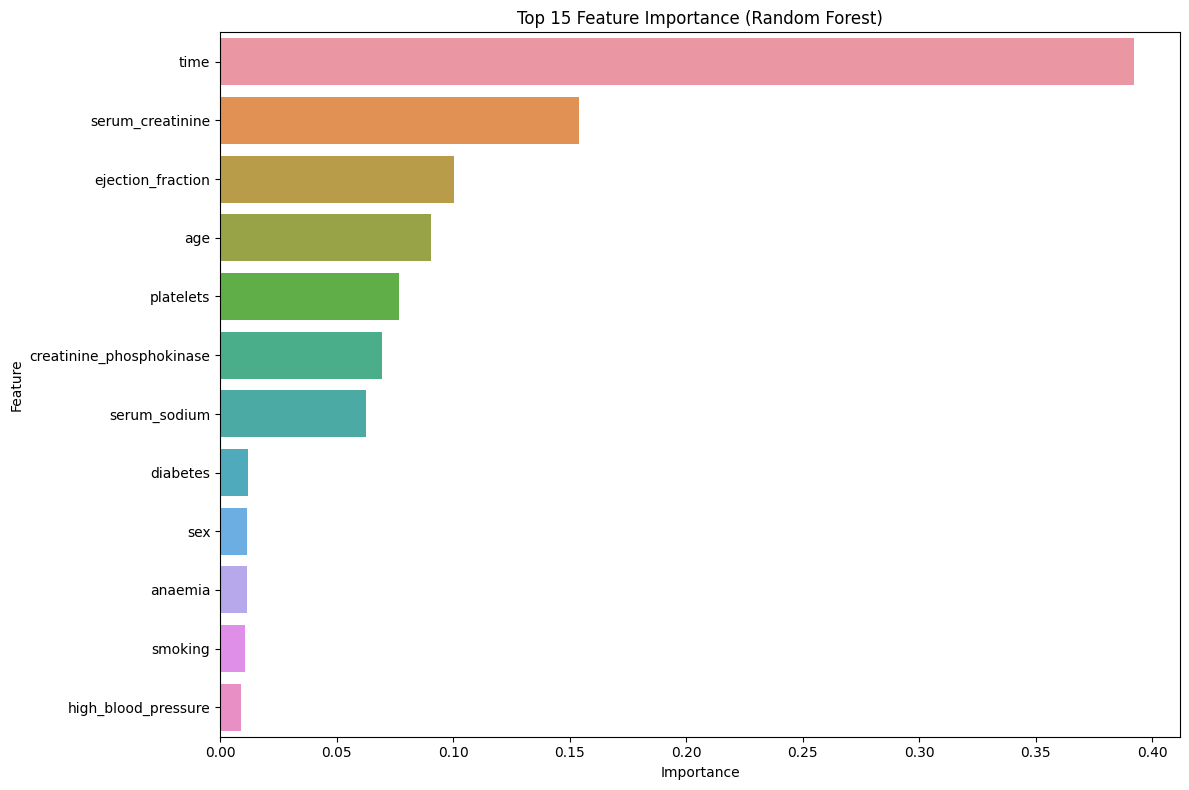

In [14]:
# Feature importance for Random Forest (as an example)
if 'Random Forest' in models:
    rf_model = models['Random Forest']
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    # Display top 15 features
    top_features = feature_importance.head(15)

    print("\nTop 15 Features Importance (Random Forest):")
    print(top_features)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 15 Feature Importance (Random Forest)')
    plt.tight_layout()
    plt.show()



<Figure size 800x600 with 0 Axes>

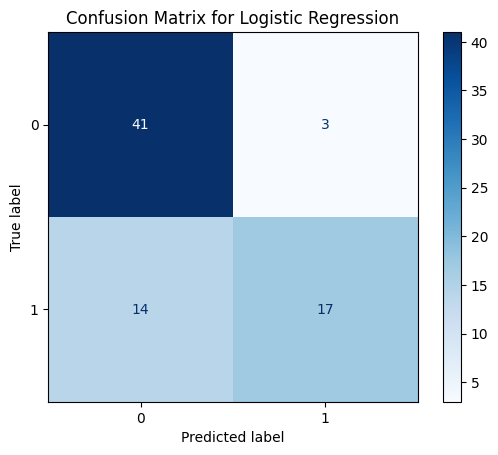

In [15]:
# Confusion matrix for the best performing model

best_model_name = results.iloc[0]['Model']
best_model = models[best_model_name]
y_pred = best_model.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()



In [16]:
# Cross-validation for the top 3 models

print("\nCross-Validation Results (5-fold):")
for name in results['Model'].head(3):
    model = models[name]
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='f1')
    print(f"{name}: Mean F1 = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")


Cross-Validation Results (5-fold):
Logistic Regression: Mean F1 = 0.5927, Std = 0.3096
Random Forest: Mean F1 = 0.4595, Std = 0.2755
Gradient Boosting: Mean F1 = 0.3544, Std = 0.2582
